# Deep Learning in Genomics (*Tutorial*)

This tutorial is a supplement to the training, if you have any questions or feedback, please contact me <linxiaowang1998@163.com>

# Outline

* **How to Use This Tutorial**
* ** 0. Background ** 
* **1. Curate the Data**
* **2. Select the Architecture and Train**
* **3. Evaluate**
* **4. Interpret**

# How to Use This Tutorial

This tutorial utilizes a Colab notebook , which is an interactive computational enviroment that combines live code, visualizations, and explanatory text. To run this notebook, you may first need to make a copy by choosing **File > Save a Copy in Drive** from the menu bar (may take a few moments to save).

The notebook is organized into a series of cells. You can modify the Python command and execute each cell as you would a Jupyter notebook. To run all of the cells at once, choose **Runtime > Run all** from the menu bar.

## 0. Background

In this tutorial, we will show how to use deep learning to approach an important problem in functional genomics: the discovery of chromatin open region.

Our positive datasets derives from the chromatin open region of human lymphoblastic cell lines(ATAC-seq), and the length of each sequence is 600bp. The selection strategy of negative datasets is to randomly sample in the interval of positive sets, and the length of each sequence is also 600bp. In order to inprove the trainging efficiency of the model, we control the ratio of positive and negative samples to 1:1.


## 1. Curate the Data

![alt text](https://github.com/wanglinxiao/deep-learning/blob/main/Screenshot%20from%202018-08-01%2020-31-01%20(2).png?raw=true)

In order to train the neural network, we must load and preprocess the data, which consists of DNA sequences and their corresponding labels.By processing this data, the network will learn to distinguish which sequences are chromation open regions or not. Firstly, we will split the data into three different sub-datasets:

(1) Training dataset: a dataset used to fit the parameters of a model or to define the weights of connections between neurons of a neural network.

(2) Validation dataset: a second dataset used to minimize overfitting. The weights of the network are not adjusted with this data set. After each training cycle, if the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then there is overfitting on the neural network.

(3) Testing dataset: is a third dataset not included in the training nor validation data sets. After all the training and validation cycles are complete, this dataset is used only for testing the final solution in order to measure the actual predictive power of the neural network on new examples.

We start by loading the necessary python libraries

In [91]:
!pip install captum
!pip install logomaker
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The next step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (more generally, ndarray or tensors).

To get each DNA sequence in the form of a matrix, we use one-hot encoding, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.

In the cell below, we show the implementation form of one-hot encoding.

In [2]:
#将序列one-hot编码
def seq_to_hot(seq):
#将序列由小写字符变为大写字符
    seq=seq.replace('a','A')
    seq=seq.replace('c','C')
    seq=seq.replace('g','G')
    seq=seq.replace('t','T')
    seq=seq.replace('n','N')
#将序列中A编码为1，其余为0
    Aseq=seq
    Aseq=Aseq.replace('A','1')
    Aseq=Aseq.replace('C','0')
    Aseq=Aseq.replace('G','0')
    Aseq=Aseq.replace('T','0')
    Aseq=Aseq.replace('N','0')
    Aseq=np.asarray(list(Aseq),dtype='float32')
#将序列中C编码为1，其余为0
    Cseq=seq
    Cseq=Cseq.replace('A','0')
    Cseq=Cseq.replace('C','1')
    Cseq=Cseq.replace('G','0')
    Cseq=Cseq.replace('T','0')
    Cseq=Cseq.replace('N','0')
    Cseq=np.asarray(list(Cseq),dtype='float32')
#将序列中G编码为1，其余为0
    Gseq=seq
    Gseq=Gseq.replace('A','0')
    Gseq=Gseq.replace('C','0')
    Gseq=Gseq.replace('G','1')
    Gseq=Gseq.replace('T','0')
    Gseq=Gseq.replace('N','0')
    Gseq=np.asarray(list(Gseq),dtype='float32')
#将序列中T编码为1，其余为0
    Tseq=seq
    Tseq=Tseq.replace('A','0')
    Tseq=Tseq.replace('C','0')
    Tseq=Tseq.replace('G','0')
    Tseq=Tseq.replace('T','1')
    Tseq=Tseq.replace('N','0')
    Tseq=np.asarray(list(Tseq),dtype='float32')
#将ACTG序列进行合并，合并成one-hot编码形式。每条长度600的DNA序列编码成4*600的向量。
    hot=np.vstack((Aseq,Cseq,Gseq,Tseq))
    
    return hot

We also go ahead and split the data into training and test sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. At a later step, we will further partition the training set into a training and validation set.

In [3]:
#将seq数据和label 组合起来
def seq_label(pos_file,neg_file,sign):
#将阳性序列和阴性序列分别保存到list中
    pos_seq_dict={}
    neg_seq_dict={}

    with open(pos_file,'r')as f:
        for line in f:
            line=line.strip()
            if line[0] == '>':
                pos_peak=line
                pos_seq_dict[pos_peak] = ''
            else:
                pos_seq=line.upper()
                pos_seq_dict[pos_peak] += pos_seq
            
    with open(neg_file,'r')as f:
        for line in f:
            line=line.strip()
            if line[0] == '>':
                neg_peak=line
                neg_seq_dict[neg_peak] = ''
            else:
                neg_seq=line.upper()
                neg_seq_dict[neg_peak] += neg_seq
                
        pos_seq_list=[]
        neg_seq_list=[]
        
        for seq in pos_seq_dict.values():
            if len(seq) == 600:
                pos_seq_list.append(seq)
        for seq in neg_seq_dict.values():
            if len(seq) == 600:
                neg_seq_list.append(seq)
        
#生成与序列数目相等的标签数目，阳性序列（label=1），阴性序列（label=0）
    if sign == 'train':
        pos_train_seq=pos_seq_list[:int(len(pos_seq_list)*0.8)]
        pos_train_label=[1 for x in range(len(pos_train_seq))]
        neg_train_seq=neg_seq_list[:int(len(neg_seq_list)*0.8)]
        neg_train_label=[0 for x in range(len(neg_train_seq))]
        
        total_seq=pos_train_seq+neg_train_seq
        total_label=pos_train_label+neg_train_label
        
    elif sign == 'vali':
        pos_vali_seq=pos_seq_list[int(len(pos_seq_list)*0.8):int(len(pos_seq_list)*0.9)]
        pos_vali_label=[1 for x in range(len(pos_vali_seq))]
        neg_vali_seq=neg_seq_list[int(len(neg_seq_list)*0.8):int(len(neg_seq_list)*0.9)]
        neg_vali_label=[0 for x in range(len(neg_vali_seq))]
        
        total_seq=pos_vali_seq+neg_vali_seq
        total_label=pos_vali_label+neg_vali_label  
        
    elif sign == 'test':
        pos_test_seq=pos_seq_list[int(len(pos_seq_list)*0.9):]
        pos_test_label=[1 for x in range(len(pos_test_seq))]
        neg_test_seq=neg_seq_list[int(len(neg_seq_list)*0.9):]
        neg_test_label=[0 for x in range(len(neg_test_seq))]
        
        total_seq=pos_test_seq+neg_test_seq
        total_label=pos_test_label+neg_test_label
    
    return total_seq,total_label

In [4]:
#将序列以one-hot编码的形式保存到list中
def generate_one_hot_seq(seq):
    hot_seq=[]
    for i in seq:
        hot_seq.append(seq_to_hot(i))
    
    hot_seq_array=np.array(hot_seq)
    return hot_seq_array

Transfer positive datasets and negative datasets to google colab

In [5]:
#输入文件（阳性集、阴性集）
pos_file='/content/human_chromatin_open.pos.txt'
neg_file='/content/human_chromatin_open.neg.txt'

In [6]:
#将每条seq序列贴上标签
train_seq,train_label=seq_label(pos_file=pos_file,neg_file=neg_file,sign='train')
vali_seq,vali_label=seq_label(pos_file=pos_file,neg_file=neg_file,sign='vali')
test_seq,test_label=seq_label(pos_file=pos_file,neg_file=neg_file,sign='test')
#将label的list属性转换成numpy属性
train_label=np.array(train_label)
vali_label=np.array(vali_label)
test_label=np.array(test_label)

In [7]:
#将seq序列one hot编码
train_data=generate_one_hot_seq(train_seq)
vali_data=generate_one_hot_seq(vali_seq)
test_data=generate_one_hot_seq(test_seq)

In [8]:
#创建pytorch Dataset
class TrainDataset(data.Dataset):
    def __init__(self):
        self.Data=train_data
        self.Label=train_label
        
    def __getitem__(self,index):
        txt=torch.from_numpy(self.Data[index])
        label=torch.tensor(self.Label[index])
        return txt,label
    
    def __len__(self):
        return len(self.Data)

class ValiDataset(data.Dataset):
    def __init__(self):
        self.Data=vali_data
        self.Label=vali_label
        
    def __getitem__(self,index):
        txt=torch.from_numpy(self.Data[index])
        label=torch.tensor(self.Label[index])
        return txt,label
    
    def __len__(self):
        return len(self.Data)
    
class TestDataset(data.Dataset):
    def __init__(self):
        self.Data=test_data
        self.Label=test_label
        
    def __getitem__(self,index):
        txt=torch.from_numpy(self.Data[index])
        label=torch.tensor(self.Label[index])
        return txt,label
    
    def __len__(self):
        return len(self.Data)

In [ ]:
#获取数据
Train=TrainDataset()
Vali=ValiDataset()
Test=TestDataset()
#构建dataloader
train_loader=data.DataLoader(Train,batch_size=64,shuffle=True,num_workers=10)
vali_loader=data.DataLoader(Vali,batch_size=64,shuffle=False,num_workers=10)
test_loader=data.DataLoader(Test,batch_size=64,shuffle=False,num_workers=10)

In [10]:
#one-hot编码序列的示例
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',train_seq[0])
print('One hot encoding of Sequence #1:\n',train_data[0])

Example sequence
-----------------------
DNA Sequence #1:
 AATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAGGCACACTCATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTAGAAATAAACATGCTAGCTTTTATTCCAGTTCTAACCAAAAAAATAAACCCTCGTTCCACAGAAGCTGCCATCAAGTATTTCCTCACGCAAGCAACCGCATCCATAATCCTTCTAATAGCTATCCTCTTCAACAATATACTCTCCGGACAATGAACCATAACCAATACCACCAATCAATACTCATCATTAATAATCATAATGGCTATAGCAATAAAACTAGGAATAGCCCCCTTTCACTTCTGAGTCCCAGAGGTTACCCAAGGCACCCCTCTGACATCCGGCCTGCTCCTTCTCACATGACAAAAACTAGCCCCCATCTCAATCATATACCAAATTTCTCCCTCATTAAACGTAAGCCTTCTCCTCACTCTTTCAATCTTATCCATCATGGCAGGCAGTTGAGGTGGATTAAACCAAACCCAACTACGCAAAATCTTAGCATACTCCTCAATTACCCACATAGGATGAATAACAGCAGTTCTACCGTACAACCCTAACATAACC
One hot encoding of Sequence #1:
 [[1. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## 2. Select the Architecture and Train

![alt text](https://github.com/wanglinxiao/deep-learning/blob/main/Screenshot%20from%202018-08-01%2020-31-49.png?raw=true)


Next, we choose a neural network architecture to train the model. In this tutorial, we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure.

Conv1D: We define three convolutional layers. The first layer has 96 filters of size 19 bases, and the following layers have 32 filters of size 11 bases.

Batch Normalization: Batch normalization was introduced by Sergey Ioffe’s and Christian Szegedy’s 2015 paper "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift." Batch normalization scales layers outputs to have mean 0 and variance 1. The outputs are scaled such a way to train the network faster. It also reduces problems due to poor parameter initialization.

MaxPooling1D: After the convolution, we use a pooling layer to down-sample the output of the convolutional filters. Though not always required, this is a typical form of non-linear down-sampling used in CNNs.

AdaptiveAvgPool1D: Apply adaptiveavgpool1D to each channel, and its function is to average the output of each channel.

Dense: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors, and the second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

We can see the details of the architecture of the neural network we have created by running summary(model), which prints the dimensionality and number of parameters for each layer in our network.

In [11]:
#定义VGGnet的结构
cfg={'VGG16':[96,'M',32,32,'M']}

#pytorch模型
class VGG(nn.Module):
    def __init__(self,vgg_name):
        super(VGG,self).__init__()
        self.feature=self.make_layers(cfg[vgg_name])
        self.fc1=nn.Linear(96,16)
        self.fc2=nn.Linear(16,1)
        
    def forward(self,x):
        out=self.feature(x)       #输出维度torch.Size([64(batch_size), 64(channel), 3(adaptivepool1d)])
        out=out.view(out.size(0),-1)   #输出维度torch.Size([64, 192])
        out=F.relu(self.fc1(out))    #输出维度torch.Size([64, 32])
        out=torch.sigmoid(self.fc2(out)) #输出维度torch.Size([64, 1])
        out=out.view(-1)         #输出维度torch.Size([64])
        return out
    
    def make_layers(self,cfg):
        layers=[]
        in_channels=4
        for x in cfg:
            if x == 'M':
                layers.append(nn.MaxPool1d(kernel_size=2,stride=2))
            elif x == 96:
                layers += [nn.Conv1d(in_channels,x,kernel_size=19),nn.BatchNorm1d(x),nn.ReLU(inplace=True)]
                in_channels=x
            elif x == 32:
                layers += [nn.Conv1d(in_channels,x,kernel_size=11),nn.BatchNorm1d(x),nn.ReLU(inplace=True)]
                in_channels=x                
        layers += [nn.AdaptiveAvgPool1d(3)]
        return nn.Sequential(*layers)

In [12]:
#模型名称VGG16
VGG16=VGG('VGG16')
summary(VGG16,(4,600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 96, 582]           7,392
       BatchNorm1d-2              [-1, 96, 582]             192
              ReLU-3              [-1, 96, 582]               0
         MaxPool1d-4              [-1, 96, 291]               0
            Conv1d-5              [-1, 32, 281]          33,824
       BatchNorm1d-6              [-1, 32, 281]              64
              ReLU-7              [-1, 32, 281]               0
            Conv1d-8              [-1, 32, 271]          11,296
       BatchNorm1d-9              [-1, 32, 271]              64
             ReLU-10              [-1, 32, 271]               0
        MaxPool1d-11              [-1, 32, 135]               0
AdaptiveAvgPool1d-12                [-1, 32, 3]               0
           Linear-13                   [-1, 16]           1,552
           Linear-14                   

In [13]:
#定义损失函数和优化器
import torch.optim as optim
criterion=nn.BCELoss()
optimizer=optim.Adam(VGG16.parameters(),lr=0.0001)

Now, we are ready to go ahead and train the neural network. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

Note: The model training takes about 4~5 minutes

In [14]:
train_loss=[]
val_loss=[]
epochs=30

for epoch in range(epochs):
#训练过程
    VGG16.train()
    train_running_loss=0
    for train_seq,train_labels in train_loader:   
#前向传播
#seq的维度torch.Size([64, 4, 600])
        train_pred=VGG16(train_seq)
        train_pred=train_pred.to(torch.float32)     #数据类型转化
        train_labels=train_labels.to(torch.float32)   #数据类型转化
        loss=criterion(train_pred,train_labels)
#反向传播
        optimizer.zero_grad()    #梯度清零
        loss.backward()       #生成梯度
        optimizer.step()      #梯度传播回网络上
#计算每个epoch下的train loss        
        train_running_loss += loss.item()   
#保存每一个epoch的训练loss
    train_loss.append(train_running_loss)

#验证过程
    VGG16.eval()
    val_running_loss=0
    for val_seq,val_labels in vali_loader:
#计算val loss
        val_pred=VGG16(val_seq)
        val_pred=val_pred.to(torch.float32)     #数据类型转化
        val_labels=val_labels.to(torch.float32)   #数据类型转化
        loss=criterion(val_pred,val_labels)
        val_running_loss += loss.item()
#保存每一个epoch下的验证loss
    val_loss.append(val_running_loss)
               
#保存每轮的model     
    model_save_path='/content/chromatin_VGG16_epoch{}'.format(epoch+1)+'.pth.tar'
    torch.save({'epoch':epoch+1,
               'model_state_dict':VGG16.state_dict(),
               'optimizer_state_dict':optimizer.state_dict(),
               'Val_loss':val_running_loss},model_save_path)

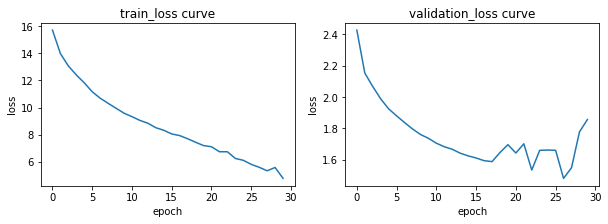

In [15]:
#绘制训练过程train loss和val loss的变化曲线
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(121)
ax1.plot(train_loss)
ax1.set_title('train_loss curve')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2=fig.add_subplot(122)
ax2.plot(val_loss)
ax2.set_title('validation_loss curve')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
plt.show()

## 3. Evaluate

![alt text](https://github.com/wanglinxiao/deep-learning/blob/main/Screenshot%20from%202018-08-01%2020-32-12.png?raw=true)

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix. 

In [16]:
#加载已经训练好的模型
model_dict=torch.load('/content/chromatin_VGG16_epoch18.pth.tar')
VGG16.load_state_dict(model_dict['model_state_dict'])
VGG16.eval()

VGG(
  (feature): Sequential(
    (0): Conv1d(4, 96, kernel_size=(19,), stride=(1,))
    (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(96, 32, kernel_size=(11,), stride=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv1d(32, 32, kernel_size=(11,), stride=(1,))
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): AdaptiveAvgPool1d(output_size=3)
  )
  (fc1): Linear(in_features=96, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Confusion matrix:
 [[83 17]
 [30 70]]


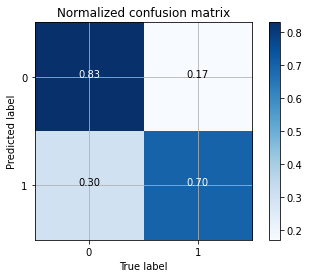

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

predict_labels=[]
predict_values=[]
test_labels=[]
for test_seq,test_label in test_loader:
  test_pred=VGG16(test_seq).detach().numpy()
  predict_values.extend(test_pred)
  batch_predict_labels=np.where(test_pred>0.5,1,0)
  predict_labels.extend(batch_predict_labels)
  test_labels.extend(test_label.numpy())

cm=confusion_matrix(y_true=test_labels,y_pred=predict_labels)
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [34]:
#precise = TP/(TP+FP)
precise=70/(30+70)
print('Precise: ',precise)

#recall = TP/(TP+FN)
recall=70/(70+17)
print('Recall: ',recall)

#auc
auc=roc_auc_score(y_true=test_labels,y_score=predict_values)
print('auc: ',auc)

Precise:  0.7
Recall:  0.8045977011494253
auc:  0.8793


## 4. Interpret

![alt text](https://github.com/wanglinxiao/deep-learning/blob/main/Screenshot%20from%202018-08-01%2020-32-31.png?raw=true)

Your results so far should allow you to conclude that the neural network is quite effective in learning to distinguish whether the sequence is chromatin accessibility or not . But can we understand why the neural network classifies a training point in the way that it does? To do so, we can compute a simple saliency map, which is the gradient of the model's prediction with respect to each individual nucleotide.

In [92]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

Next, we need to define input and baseline tensors. Baselines belong to the input space and often carry no predictive signal. Zero tensor can serve as a baseline for many tasks. Some interpretability algorithms such as IntegratedGradients, Deeplift and GradientShap are designed to attribute the change between the input and baseline to a predictive class or a value that the neural network outputs.

In [93]:
#选择训练集的一条序列做示例
input1=train_data[3]
input1=torch.from_numpy(input1)
input1=torch.unsqueeze(input1,0)  #(1,4,600)

baseline=torch.zeros(1,4,600)

Next we will use IntegratedGradients algorithms to assign attribution scores to each input feature with respect to the target output.

In [95]:
ig = IntegratedGradients(VGG16)
attributions, delta = ig.attribute(input1, baseline, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

IG Attributions: tensor([[[-0.0000e+00,  2.1552e-05, -0.0000e+00,  ...,  3.7245e-06,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-4.0036e-06,  0.0000e+00, -1.0094e-07,  ..., -0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]], dtype=torch.float64)
Convergence Delta: tensor([-0.0008], dtype=torch.float64)


Positive attribution score means that the input in that particular position positively contributed to the final prediction and negative means the opposite. The magnitude of the attribution score signifies the strength of the contribution. Zero attribution score means no contribution from that particular feature.

In [98]:
df_attributions=pd.DataFrame(torch.squeeze(attributions,0).numpy(),index=['A','C','G','T'],columns=[i for i in range(1,601)])
df_attributions

,1,2,3,4,5,6,7,8,9,10,...,591,592,593,594,595,596,597,598,599,600
A,-0.000000,0.000022,-0.000000e+00,0.000000,-0.000000,-0.000014,-0.000146,-0.000077,0.000000,-0.000000,...,-0.000000,-0.000021,-0.00002,0.000000,-0.000025,-0.00001,-0.000000,0.000004,0.0,0.0
C,0.000000,-0.000000,0.000000e+00,0.000000,0.000102,-0.000000,0.000000,0.000000,-0.000000,0.000028,...,0.000119,0.000000,0.00000,0.000034,0.000000,0.00000,-0.000000,0.000000,0.0,0.0
G,-0.000004,0.000000,-1.009370e-07,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000007,0.000000,...,0.000000,0.000000,-0.00000,0.000000,0.000000,0.00000,0.000000,-0.000000,0.0,0.0
T,0.000000,-0.000000,-0.000000e+00,-0.000007,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,...,-0.000000,-0.000000,-0.00000,0.000000,0.000000,-0.00000,-0.000009,0.000000,0.0,0.0


According to the contribution score of test sequence, we draw the logo figure below. Then, we can combine the known motif database(such as JASPAR, TRANSFACT) to determine which transcript factor may be contained in the input sequence.

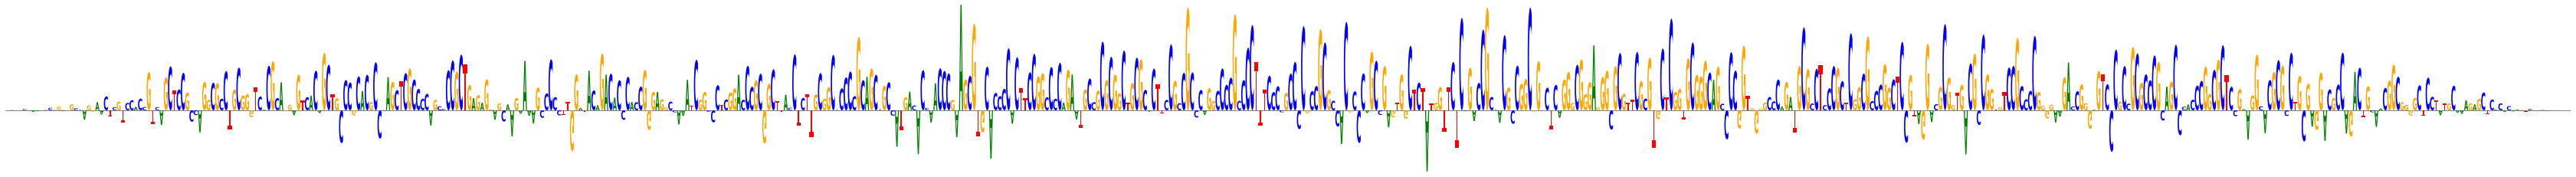

In [99]:
fig,ax=plt.subplots(figsize=(60,4))

#绘制输入序列logo图
nn_logo = logomaker.Logo(df_attributions.T,ax=ax)
nn_logo.ax.set_xticks([])
nn_logo.ax.set_yticks([])

#取消边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)